# Pongsakorn Tanupatrasakul 
# Content
<b>Sections</b>
<ol>
    <li>Preproccessing</li>
    <li>Modelling</li>
    <li>Evaluation</li>

# Libraries 

In [1]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from shutil import move
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Flatten,Conv2D,MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix, accuracy_score, recall_score

# preproccessing 

In [2]:
trainlabel = 'data/trainlabels.txt'
testlabel = 'data/testlabels.txt'
vallabel = 'data/vallabels.txt'
train_path = 'data/train/'
val_path = 'data/val/'
test_path = 'data/test/'

Lets take a peek on what the txt data looks like

In [9]:
print([i for i in open(testlabel,'r')][:5])

['image label\n', 'test/image_189342.jpg 0\n', 'test/image_145102.jpg 0\n', 'test/image_31546.jpg 0\n', 'test/image_441280.jpg 1\n']


### The text split function read the txt line by line then use string slicing to make the file name the key and indexing to take the label as it value according to the filename

In [4]:
def textsplit(x):
    l = dict()
    for i in open(x, 'r'):
        slash = i.find('/')+1
        key = i[slash:-3]
        l[key] = i[-2]
    return l

Apply the function to the train,val and test label transforming it to dictionary

In [5]:
trainlabel = textsplit(trainlabel)
testlabel = textsplit(testlabel)
vallabel = textsplit(vallabel)

#### The binarylabelfile function create 2 new folders called negative and positive to prepare the data into it specific label and correct format for image generator 

In [6]:
def binarylabelfile(path):
    try:
        os.mkdir(path+'/negative')
        os.mkdir(path+'/positive')
    except:
        print('File already existed')

Apply the function on every path to create the folder

In [7]:
binarylabelfile(train_path)
binarylabelfile(val_path)
binarylabelfile(test_path)

File already existed
File already existed
File already existed


#### Movetolabel function move imagefile to it category(postive/negative) by using the label dictionary

In [8]:
def movetolabel(path,label):
    posneg = {'0':'negative/', '1':'positive/'}
    for i in os.listdir(path):
        try:
            result= posneg[label[i]]
            move(path+i,path+result)
        except:
            if i[-3:]=='jpg':
                os.remove(path+i)

Apply the function to every path to categorize every path to its category

In [9]:
movetolabel(test_path,testlabel)
movetolabel(train_path,trainlabel)
movetolabel(val_path,vallabel)

### Lets decide on the image size by using the average sum of each dimension

In [10]:
dim1 = []
dim2 = []
for i in os.listdir(test_path+'positive/'):
    d1,d2 = plt.imread(test_path+'positive/'+i).shape
    dim1.append(d1)
    dim2.append(d2)

### the jointplot shows as that all dim1 and dim2 of the images are all 50x50

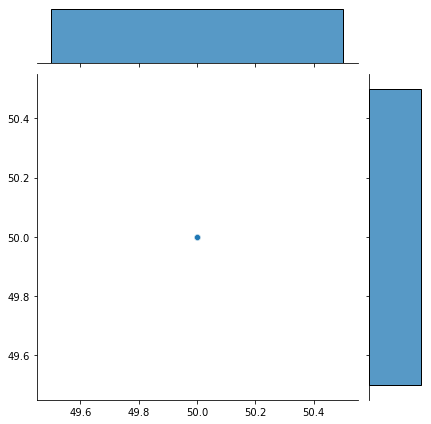

In [11]:
sns.jointplot(x = dim1, y=dim2)

In [12]:
np.mean(dim1)

50.0

In [13]:
np.mean(dim2)

50.0

### The input shape for our model

In [14]:
image_shape = (50,50,3)

# Modelling

for modelling, lets use the imagedatagenerator module with rescale parameter to rescale/ standardize the data, set dtype to float and according to the paper we are usign zoom 0.2 and horizontal flip.

In [15]:
image_gen = ImageDataGenerator(rescale=1/255.0,dtype='float', zoom_range=0.2, horizontal_flip=True)

#### Identifying the batch size( we will use batch_size of 32 accordingly to the study conducted)

In [16]:
batch_size = 32

##### Setting the learning rate of 0.0001

In [17]:
lr = 0.0001

##### Create generator from directory forming 3 generator from train, test and val path but change the color mode to rgb since imagenet on transfer learning requires 3 channel 

In [18]:
train_gen = image_gen.flow_from_directory(train_path,target_size = image_shape[:2],color_mode='rgb', batch_size=batch_size,shuffle=True,class_mode ='binary')
val_gen  = image_gen.flow_from_directory(val_path, target_size = image_shape[:2],color_mode='rgb', batch_size=batch_size,shuffle=True,class_mode ='binary')
test_gen = image_gen.flow_from_directory(test_path , target_size = image_shape[:2],color_mode='rgb', batch_size=batch_size,shuffle=False,class_mode ='binary')

Found 5199 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.
Found 1624 images belonging to 2 classes.


###### Train_gen has two classes same as the file name we structure for the generator path

In [19]:
train_gen.class_indices

{'negative': 0, 'positive': 1}

##### Importing the vgg16, vgg19 and resnet50 architectures from keras.applications

In [20]:
from tensorflow.keras.applications import VGG16,VGG19,ResNet50
pretrain_vgg16  = VGG16( include_top=False,weights='imagenet', input_shape=image_shape)
pretrain_vgg19 = VGG19( include_top=False,weights = 'imagenet', input_shape=image_shape)
pretrain_resnet50 = ResNet50( include_top=False,weights='imagenet', input_shape=image_shape)

2022-03-09 15:32:29.372275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 15:32:29.372406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
94781440/94765736 [==============================] - 28s 0us/step


##### Summary of vgg16 architecture

In [21]:
pretrain_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

##### summary of vgg19 architecture

In [22]:
pretrain_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

#### summary of resnet50 architecture

In [23]:
pretrain_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

###### Creating the CNN model with sequential with pretrain model

In [24]:
model_vgg19 = Sequential()
model_vgg16 = Sequential()
model_resnet50 = Sequential()

### lets add earlystopping of 20 accordingly to the research

In [25]:
earlystop = EarlyStopping(monitor='val_loss', patience=20)

### the function below add the pretrain model into the sequential then flatten it insert 3 x stack of dense,batchnormalization and dropout (according to the paper)  then set the output to one neuron with sigmoid as it is a binary classification of positive or negative

In [26]:
def output_layeradder(model, pretrain):
    model.add(pretrain)
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=lr), metrics = ['acc'])

#### Applying the function to the pretrain architectures this will automatically update the models with flatten and output layer

In [27]:
output_layeradder(model_vgg16, pretrain_vgg16)
output_layeradder(model_vgg19, pretrain_vgg19)
output_layeradder(model_resnet50, pretrain_resnet50)

#### summary of all the models after adding the output layer

In [28]:
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [29]:
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                        

In [30]:
model_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                524352    
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                      

#### Fitting the vgg19 model

In [31]:
model_vgg19.fit(train_gen, epochs=1000,validation_data=val_gen,callbacks=[earlystop])

2022-03-09 15:34:07.766668: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2022-03-09 15:34:08.230388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.8551 - acc: 0.5345

2022-03-09 15:34:25.540704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 25s 145ms/step - loss: 0.8551 - acc: 0.5345 - val_loss: 1.5757 - val_acc: 0.1726
Epoch 2/1000
163/163 [==============================] - 20s 122ms/step - loss: 0.7414 - acc: 0.5951 - val_loss: 0.8376 - val_acc: 0.4037
Epoch 3/1000
163/163 [==============================] - 25s 156ms/step - loss: 0.5654 - acc: 0.7098 - val_loss: 0.4120 - val_acc: 0.8213
Epoch 4/1000
163/163 [==============================] - 18s 112ms/step - loss: 0.4686 - acc: 0.7819 - val_loss: 0.8157 - val_acc: 0.4445
Epoch 5/1000
163/163 [==============================] - 19s 116ms/step - loss: 0.4389 - acc: 0.8103 - val_loss: 0.4416 - val_acc: 0.8436
Epoch 6/1000
163/163 [==============================] - 22s 135ms/step - loss: 0.3717 - acc: 0.8504 - val_loss: 0.4821 - val_acc: 0.8667
Epoch 7/1000
163/163 [==============================] - 22s 137ms/step - loss: 0.3273 - acc: 0.8725 - val_loss: 0.4476 - val_acc: 0.8975
Epoch 8/1000
163/163 [==============================] 

#### Fitting the vgg16 model

In [32]:
model_vgg16.fit(train_gen, epochs=1000,validation_data=val_gen,callbacks=[earlystop])

Epoch 1/1000


2022-03-09 16:15:12.381521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.9036 - acc: 0.5091

2022-03-09 16:15:27.490489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 23s 137ms/step - loss: 0.9036 - acc: 0.5091 - val_loss: 1.0884 - val_acc: 0.3891
Epoch 2/1000
163/163 [==============================] - 21s 126ms/step - loss: 0.7037 - acc: 0.6022 - val_loss: 3.1671 - val_acc: 0.8274
Epoch 3/1000
163/163 [==============================] - 27s 163ms/step - loss: 0.6067 - acc: 0.6859 - val_loss: 0.5372 - val_acc: 0.8059
Epoch 4/1000
163/163 [==============================] - 19s 119ms/step - loss: 0.4982 - acc: 0.7675 - val_loss: 0.5103 - val_acc: 0.7928
Epoch 5/1000
163/163 [==============================] - 26s 160ms/step - loss: 0.4274 - acc: 0.8200 - val_loss: 0.7571 - val_acc: 0.6194
Epoch 6/1000
163/163 [==============================] - 21s 128ms/step - loss: 0.3749 - acc: 0.8465 - val_loss: 0.5531 - val_acc: 0.7242
Epoch 7/1000
163/163 [==============================] - 21s 127ms/step - loss: 0.3297 - acc: 0.8656 - val_loss: 0.3230 - val_acc: 0.9114
Epoch 8/1000
163/163 [==============================] 

#### Fitting the resnet50 model

In [33]:
model_resnet50.fit(train_gen, epochs=1000,validation_data=val_gen,callbacks=[earlystop])

Epoch 1/1000


2022-03-09 16:41:20.826206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - ETA: 0s - loss: 0.9300 - acc: 0.5222

2022-03-09 16:41:39.464694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 26s 138ms/step - loss: 0.9300 - acc: 0.5222 - val_loss: 0.4710 - val_acc: 0.8274
Epoch 2/1000
163/163 [==============================] - 19s 117ms/step - loss: 0.7792 - acc: 0.5795 - val_loss: 0.5564 - val_acc: 0.7542
Epoch 3/1000
163/163 [==============================] - 21s 129ms/step - loss: 0.6528 - acc: 0.6701 - val_loss: 0.4963 - val_acc: 0.8120
Epoch 4/1000
163/163 [==============================] - 20s 120ms/step - loss: 0.5487 - acc: 0.7359 - val_loss: 0.5612 - val_acc: 0.8413
Epoch 5/1000
163/163 [==============================] - 21s 128ms/step - loss: 0.4867 - acc: 0.7973 - val_loss: 0.5028 - val_acc: 0.8590
Epoch 6/1000
163/163 [==============================] - 20s 124ms/step - loss: 0.4093 - acc: 0.8432 - val_loss: 0.4137 - val_acc: 0.8914
Epoch 7/1000
163/163 [==============================] - 21s 129ms/step - loss: 0.3398 - acc: 0.8852 - val_loss: 0.3679 - val_acc: 0.9114
Epoch 8/1000
163/163 [==============================] 

## Evaluation

#### lossacc has one parameter that takes in model so it can plot loss val_loss and accuracy val_accuracy

In [34]:
def lossacc(model):
    df = pd.DataFrame(model.history.history)
    df[['loss','val_loss']].plot()
    df[['acc','val_acc']].plot()

## Loss and acc for vgg16

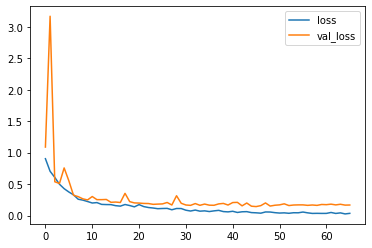

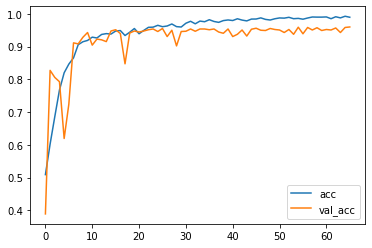

In [35]:
lossacc(model_vgg16)

## Loss and acc for vgg19

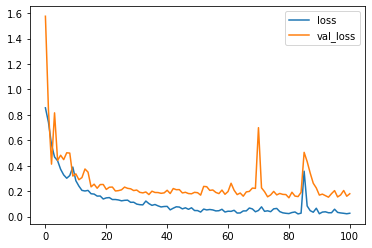

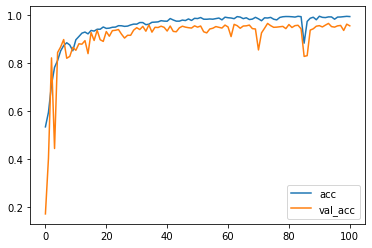

In [36]:
lossacc(model_vgg19)

## Loss and acc for resnet50

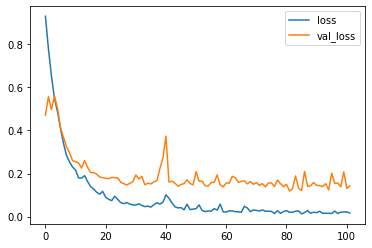

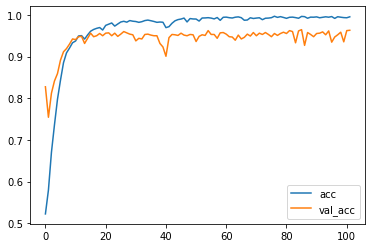

In [37]:
lossacc(model_resnet50)

The <b>gety_pred parameter</b> take in 2 input which is model and testgen then predict the ypred to get the optimum cutoff point that round the ypred to either 1 or 0 then return it

In [38]:
def gety_pred(model, testgen):
    y_pred = model.predict(testgen)
    fpr, tpr, threshold=roc_curve(test_gen.classes,y_pred)
    idx = np.argmax(np.abs(tpr - fpr))
    cutoff = threshold[idx]
    y_pred = 1*(y_pred>=cutoff)
    return y_pred

Apply the function

In [39]:
vgg16_ypred = gety_pred(model_vgg16, test_gen)
vgg19_ypred = gety_pred(model_vgg19, test_gen)
resnet50_ypred = gety_pred(model_resnet50, test_gen)

2022-03-09 17:16:06.792530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-09 17:16:18.412350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-09 17:16:27.574847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


This function below plot the confusion matrix and classification report

In [40]:
def confusionmatrix_report(truegen, y_pred):
    sns.heatmap(confusion_matrix(truegen.classes, y_pred), annot=True, cmap='viridis', fmt='g')
    print(classification_report(truegen.classes, y_pred))

## Vgg16 confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1342
           1       0.83      0.92      0.87       282

    accuracy                           0.95      1624
   macro avg       0.90      0.94      0.92      1624
weighted avg       0.96      0.95      0.95      1624



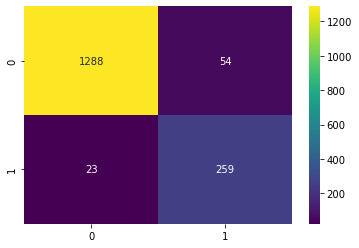

In [41]:
confusionmatrix_report(test_gen, vgg16_ypred)

## Vgg19 confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1342
           1       0.84      0.92      0.88       282

    accuracy                           0.96      1624
   macro avg       0.91      0.94      0.92      1624
weighted avg       0.96      0.96      0.96      1624



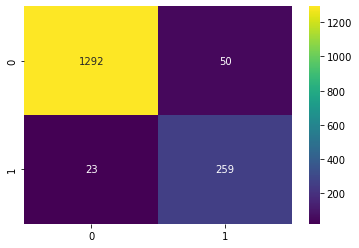

In [42]:
confusionmatrix_report(test_gen, vgg19_ypred)

## Resnet50 confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1342
           1       0.79      0.93      0.86       282

    accuracy                           0.95      1624
   macro avg       0.89      0.94      0.91      1624
weighted avg       0.95      0.95      0.95      1624



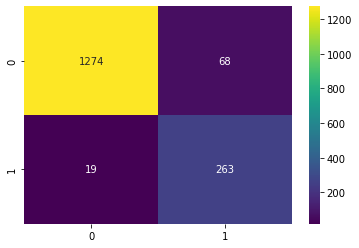

In [43]:
confusionmatrix_report(test_gen, resnet50_ypred)

The metricsreturn function will yield accuracy, sensitivity and specificity

In [44]:
def metricsreturn(test_gen, y_pred):
    accuracy = accuracy_score(test_gen.classes, y_pred)
    sensitivity = recall_score(test_gen.classes, y_pred)
    tp, fp, fn, tn = confusion_matrix(test_gen.classes, y_pred).ravel()
    specificity = tn / (tn+fp) # since there is no function for specificity
    return [accuracy, sensitivity, specificity]

apply the function

In [45]:
vgg16score = metricsreturn(test_gen, vgg16_ypred)
vgg19score = metricsreturn(test_gen, vgg19_ypred)
resnet50score = metricsreturn(test_gen, resnet50_ypred)

### put it into the dataframe for easier visualization

In [46]:
df = pd.DataFrame([vgg16score,vgg19score,resnet50score], columns = ['accuracy', 'sensitivity', 'specificity'], index = ['vgg16','vgg19','resnet50'])
df

,accuracy,sensitivity,specificity
vgg16,0.952586,0.918440,0.827476
vgg19,0.955049,0.918440,0.838188
resnet50,0.946429,0.932624,0.794562
